# About Edit Demo
This notebook will show you a demo of video editing implemented through the BMF framework: through the Module that realizes two features used subgraph, it provides the overlay and concat capabilities of multiple audio and video channels, and completes a complex video editing pipeline.

# 1. Install BMF in Python environment.

In [9]:
!gdown --fuzzy https://drive.google.com/file/d/10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S/view?usp=sharing -O bmf-0.1.0-cp310-none-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S
To: /content/bmf-0.1.0-cp310-none-linux_x86_64.whl
100% 52.6M/52.6M [00:01<00:00, 48.7MB/s]


In [10]:
!pip install bmf-0.1.0-cp310-none-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./bmf-0.1.0-cp310-none-linux_x86_64.whl
bmf is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


## 2.The Engine layer of the BMF framework is uniformly implemented in C++ language. In Colab, when python calls the C++ library, the log of the C++ library layer will be hidden, so it is necessary to install and load the wurlitezer library to enable logs in the C++ layer.

In [11]:
!pip install wurlitzer
%load_ext wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


## 3. Download a sample transcoded video (using Big Bunny as an example here) and watermark of XiGua.

In [12]:
!gdown --fuzzy https://drive.google.com/file/d/1l8bDSrWn6643aDhyaocVStXdoUbVC3o2/view?usp=sharing -O big_bunny_10s_30fps.mp4
!gdown --fuzzy https://drive.google.com/file/d/1VHxQdIStg1pr7sNlORhUDroIhm3sIcvy/view?usp=sharing -O xigua_prefix_logo_x.mov

Downloading...
From: https://drive.google.com/uc?id=1l8bDSrWn6643aDhyaocVStXdoUbVC3o2
To: /content/big_bunny_10s_30fps.mp4
100% 2.56M/2.56M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VHxQdIStg1pr7sNlORhUDroIhm3sIcvy
To: /content/xigua_prefix_logo_x.mov
100% 1.47M/1.47M [00:00<00:00, 10.8MB/s]


## 4. Write and implement Edit Demo
### Overall, Edit Demo can be decomposed into three sub-processes:
### 1. Implement the video_overlay subgraph module.
### 2. Implement the video_concat subgraph module.
### 3. Build the work pipeline of Edit Demo.
We will analyze in detail the above three processes one by one.

### Implement the video_overlay subgraph module
The following code implements a video_overlay Module with Python, this module receives a source stream (the first element of a list by default) and several overlay streams, and configures options through custom parameters to implement a process that makes FFmpeg overlay operation between all incoming overlay streams and source stream. You may have questions: why does the video_overlay Module not directly inherit class Module, but inherit class SubGraph? In fact, this is a sub-function of the BMF framework: SubGraph. If you want to know more about the functions and mechanisms of SubGraph, please go to: link to SubGraph. Here, you only need to understand one thing: SubGraph essentially exists as a Module, and it also constructs a graph structure internally, and this graph structure will participate in the calculation of the overall pipeline as the content of the Module.

The option of video_overlay has two important properties: source and overlays:

**source**: A set of descriptions of the original code stream (or overlay code stream) and related feature descriptions, dictionary structure.

**overlays**: a list, each element in the list is a description dictionary corresponding to the overlay stream, such a dictionary can have multiple.

In the create_graph function logic, the program builds a graph for overlay operations on a source stream and multiple overlay streams.

In [13]:
import bmf
from bmf import bmf_sync, Packet
from bmf import SubGraph

'''
Option example:
    option = {
        "source": {
            "start": 0,
            "duration": 5,
            "width": 640,
            "height": 480
        },
        "overlays": [
            {
                "start": 0,
                "duration": 2,
                "width": 300,
                "height": 200,
                "pox_x": 0,
                "pox_y": 0,
                "loop": -1,
                "repeat_last": 0
            },
            {
                "start": 2,
                "duration": 2,
                "width": 300,
                "height": 200,
                "pox_x": 'W-300',
                "pox_y": 0,
                "loop": 0,
                "repeat_last": 1
            }
        ]
    }
'''


class video_overlay(SubGraph):
    def create_graph(self, option=None):
        # create source stream
        self.inputs.append('source')
        source_stream = self.graph.input_stream('source')
        # create overlay stream
        overlay_streams = []
        for (i, _) in enumerate(option['overlays']):
            self.inputs.append('overlay_' + str(i))
            overlay_streams.append(self.graph.input_stream('overlay_' + str(i)))

        # pre-processing for source layer
        info = option['source']
        output_stream = (
            source_stream.scale(info['width'], info['height'])
                .trim(start=info['start'], duration=info['duration'])
                .setpts('PTS-STARTPTS')
        )

        # overlay processing
        for (i, overlay_stream) in enumerate(overlay_streams):
            overlay_info = option['overlays'][i]

            # overlay layer pre-processing
            p_overlay_stream = (
                overlay_stream.scale(overlay_info['width'], overlay_info['height'])
                    .loop(loop=overlay_info['loop'], size=10000)
                    .setpts('PTS+%f/TB' % (overlay_info['start']))
            )

            # calculate overlay parameter
            x = 'if(between(t,%f,%f),%s,NAN)' % (overlay_info['start'],
                                                 overlay_info['start'] + overlay_info['duration'],
                                                 str(overlay_info['pox_x']))
            y = 'if(between(t,%f,%f),%s,NAN)' % (overlay_info['start'],
                                                 overlay_info['start'] + overlay_info['duration'],
                                                 str(overlay_info['pox_y']))
            if overlay_info['loop'] == -1:
                repeat_last = 0
                shortest = 1
            else:
                repeat_last = overlay_info['repeat_last']
                shortest = 1

            # do overlay
            output_stream = (
                output_stream.overlay(p_overlay_stream, x=x, y=y,
                                      repeatlast=repeat_last)
            )

        # finish creating graph
        self.output_streams = self.finish_create_graph([output_stream])

### Implement the subgraph module:video_concat

Similar to the video_overlay module described above, video_concat is also a subgraph, and the option with protocol parameters has the following important attributes:

width: the width of the source video

height: the height of the source video

has_audio: whether audio stream is required

video_list: an array, each element is a description of a video stream:

1. **start**: The video output stream requires the start time
2. **duration**: The duration required by the video output stream
3. **transition_time**: the start time of the transition operation

In the processing logic, the module will loop and iteratively process the video stream. For each incoming video stream, first call the scale filter once to scale the video stream to the corresponding resolution, and then call the split filter to copy one video stream into two. Next, do Trim and Setpts operations on the first video stream, then check whether there is a prev_transition video stream, if yes, perform an overlay operation on the two video streams and store them in the concat array, if not, do not process. Finally, another video stream that has just been split, its start time will be set with (duration - transition_time), transition_time will be the duration of the video stream with Trim operation and SetPts operation before, and finally scaled to a fixed resolution of 200x200 and saved as the prev_transition video stream.


For audio streams, if the user sets has_audio = 1, the module will also concat each audio stream by default, and the duration of each audio stream used for concat will align with the duration of the corresponding video stream.

In [24]:
'''
Option example:
    option = {
        "width": 640,
        "height": 480,
        "has_audio": 1,
        "video_list": [
            {
                "start": 0,
                "duration": 2,
                "transition_time": 1,
                "transition_mode": 1
            },
            {
                "start": 0,
                "duration": 4,
                "transition_time": 1,
                "transition_mode": 1
            },
            {
                "start": 3,
                "duration": 4,
                "transition_time": 1,
                "transition_mode": 1
            }
        ]
    }
'''


class video_concat(SubGraph):
    def create_graph(self, option=None):
        video_stream_cnt = len(option['video_list'])

        # here we assume if have audio, audio stream count is equal to video
        if option['has_audio'] == 1:
            audio_stream_cnt = video_stream_cnt
        else:
            audio_stream_cnt = 0

        # process video streams
        concat_video_streams = []
        prev_transition_stream = None
        for i in range(video_stream_cnt):
            # create a input stream
            stream_name = 'video_' + str(i)
            self.inputs.append(stream_name)
            video_stream = (
                self.graph.input_stream(stream_name)
                    .scale(option['width'], option['height'])
            )

            if option['video_list'][i]['transition_time'] > 0 and i < video_stream_cnt - 1:
                split_stream = video_stream.split()
                video_stream = split_stream[0]
                transition_stream = split_stream[1]
            else:
                transition_stream = None

            # prepare concat stream
            info = option['video_list'][i]
            trim_time = info['duration'] - info['transition_time']
            concat_stream = (
                video_stream.trim(start=info['start'], duration=trim_time)
                    .setpts('PTS-STARTPTS')
            )

            # do transition, here use overlay instead
            if prev_transition_stream is not None:
                concat_stream = concat_stream.overlay(prev_transition_stream, repeatlast=0)

            # add to concat stream
            concat_video_streams.append(concat_stream)

            # prepare transition stream for next stream
            if transition_stream is not None:
                prev_transition_stream = (
                    transition_stream.trim(start=trim_time, duration=info['transition_time'])
                        .setpts('PTS-STARTPTS')
                        .scale(200, 200)
                )

        # concat videos
        concat_video_stream = bmf.concat(*concat_video_streams, n=video_stream_cnt, v=1, a=0)

        # process audio
        # actually, we can use another sub-graph module to process audio, we combine it
        # in one module to show how to process multi-output in sub-graph
        concat_audio_stream = None
        if audio_stream_cnt > 0:
            concat_audio_streams = []
            for i in range(audio_stream_cnt):
                # create a input stream
                stream_name = 'audio_' + str(i)
                self.inputs.append(stream_name)

                # pre-processing for audio stream
                info = option['video_list'][i]
                trim_time = info['duration'] - info['transition_time']
                audio_stream = (
                    self.graph.input_stream(stream_name)
                        .atrim(start=info['start'], duration=trim_time)
                        .asetpts('PTS-STARTPTS')
                        .afade(t='in', st=0, d=2)
                        .afade(t='out', st=info['duration'] - 2, d=2)
                )

                # add to concat stream
                concat_audio_streams.append(audio_stream)

            # concat audio
            concat_audio_stream = bmf.concat(*concat_audio_streams, n=audio_stream_cnt, v=0, a=1)

        # finish creating graph
        self.output_streams = self.finish_create_graph([concat_video_stream, concat_audio_stream])

## Implement a complex video editing pipeline

This code calls the two modules implemented above, first creates three video streams, overlays them with the logo of Xigua Video respectively, then sends the three processed video streams and corresponding audio streams to video_concat module, a complex audio and video editing Demo is implemented, in which the topology of the bmf graph can be represented by the following figure:

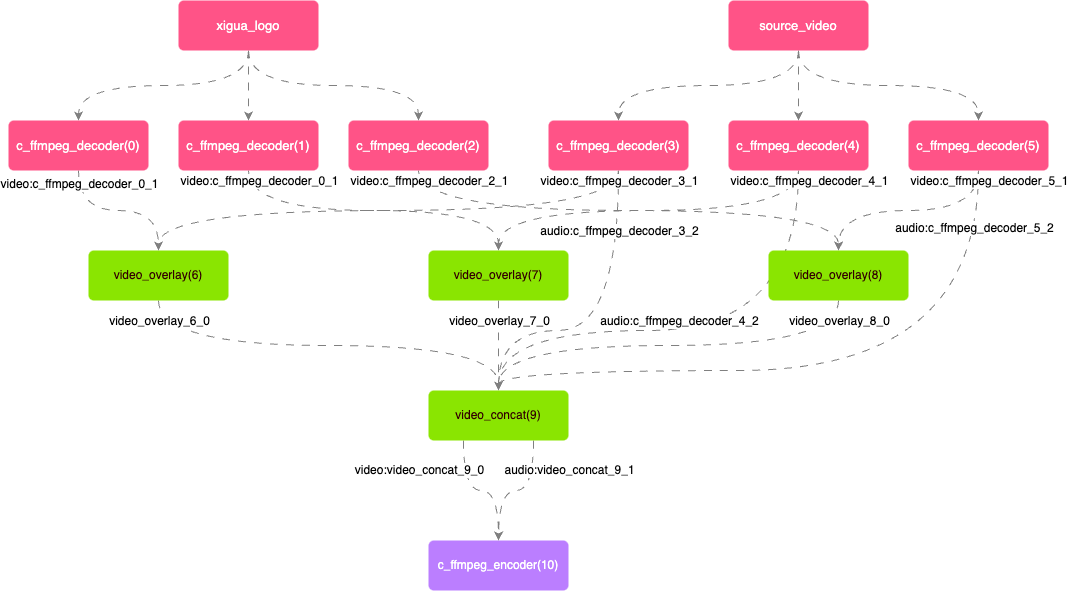




In [25]:
input_video_path = "./big_bunny_10s_30fps.mp4"
logo_path = "./xigua_prefix_logo_x.mov"
output_path = "./complex_edit.mp4"
dump_graph = 0
# create graph
duration = 10

overlay_option = {
    "dump_graph": dump_graph,
    "source": {
        "start": 0,
        "duration": duration,
        "width": 1280,
        "height": 720
    },
    "overlays": [
        {
            "start": 0,
            "duration": duration,
            "width": 300,
            "height": 200,
            "pox_x": 0,
            "pox_y": 0,
            "loop": 0,
            "repeat_last": 1
        }
    ]
}

concat_option = {
    "dump_graph": dump_graph,
    "width": 1280,
    "height": 720,
    # if have audio input
    "has_audio": 1,
    "video_list": [
        {
            "start": 0,
            "duration": duration,
            "transition_time": 2,
            "transition_mode": 1
        },
        {
            "start": 0,
            "duration": duration,
            "transition_time": 2,
            "transition_mode": 1
        },
        {
            "start": 0,
            "duration": duration,
            "transition_time": 2,
            "transition_mode": 1
        }
    ]
}

# create graph
my_graph = bmf.graph({
    "dump_graph": dump_graph
})

# three logo video
logo_1 = my_graph.decode({'input_path': logo_path})['video']
logo_2 = my_graph.decode({'input_path': logo_path})['video']
logo_3 = my_graph.decode({'input_path': logo_path})['video']

# three videos
video1 = my_graph.decode({'input_path': input_video_path})
video2 = my_graph.decode({'input_path': input_video_path})
video3 = my_graph.decode({'input_path': input_video_path})

# do overlay
overlay_streams = list()
overlay_streams.append(bmf.module([video1['video'], logo_1], 'video_overlay', overlay_option, entry='__main__.video_overlay')[0])
overlay_streams.append(bmf.module([video2['video'], logo_2], 'video_overlay', overlay_option, entry='__main__.video_overlay')[0])
overlay_streams.append(bmf.module([video3['video'], logo_3], 'video_overlay', overlay_option, entry='__main__.video_overlay')[0])

# do concat
concat_streams = (
    bmf.module([
        overlay_streams[0],
        overlay_streams[1],
        overlay_streams[2],
        video1['audio'],
        video2['audio'],
        video3['audio']
    ], 'video_concat', concat_option, entry='__main__.video_concat')
)

# encode
(
    bmf.encode(concat_streams[0], concat_streams[1], {
        "output_path": output_path,
        "video_params": {
            "width": 1280,
            "height": 720,
            'codec': 'h264'
        }
    }).run()
)

{
    "input_streams": [],
    "output_streams": [],
    "nodes": [
        {
            "module_info": {
                "name": "c_ffmpeg_decoder",
                "type": "",
                "path": "",
                "entry": ""
            },
            "meta_info": {
                "premodule_id": -1,
                "callback_binding": []
            },
            "option": {
                "input_path": "./xigua_prefix_logo_x.mov"
            },
            "input_streams": [],
            "output_streams": [
                {
                    "identifier": "video:c_ffmpeg_decoder_297_1",
                    "stream_alias": ""
                }
            ],
            "input_manager": "immediate",
            "scheduler": 0,
            "alias": "",
            "id": 297
        },
        {
            "module_info": {
                "name": "c_ffmpeg_decoder",
                "type": "",
                "path": "",
                "entry": ""
            },
     

## 5. Display the video streams before and after processing.

In [16]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return f"""
  <video width={video_width} controls>
    <source src="{video_url}">
  </video>
  """
  
video_url1 = show_video('big_bunny_10s_30fps.mp4')
video_url2 = show_video('complex_edit.mp4')

html = video_url1 + video_url2
HTML(html)